In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab.patches import cv2_imshow # cv2_imshow(img)
import cv2
import urllib.request
import numpy as np
import time
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import PIL.Image
import matplotlib.image as img
import IPython.display as display

In [5]:
def model_layers(layer_names): # 전역 변수, StyleContentModel에 이용
    """ 중간층의 출력값을 배열로 반환하는 < > 모델을 만듭니다."""
    # 이미지넷 데이터셋에 사전학습된 < > 모델을 불러옵니다
    # ✅ 모델 선택 가능  tf.keras.applications 문서 참고
    model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    model.trainable = False    
    outputs = [model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([model.input], outputs)
    return model

In [6]:
def load_img(path_to_img): # main, 전역변수
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img, new_shape   # 사진 크기에 따른 자동화 문제 해결

In [7]:
# 전역 변수
# ✅ 모델 바꿀 시 변경 필요
content_layers = ['block5_conv2']  # style_content_loss, 전역변수  extractor
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']     # style_content_loss, 전역변수 extractor

style_location = 'Style_Images/horror3.jpg'
style_image, style_shape = load_img(style_location) # style_content_loss, 전역변수 style_outputs

style_extractor = model_layers(style_layers)
style_outputs = style_extractor(style_image*255) # style_content_loss, StyleContentModel

In [8]:
style_shape

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([328, 512], dtype=int32)>

In [9]:
def gram_matrix(input_tensor): # StyleContentModel
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [10]:
class StyleContentModel(tf.keras.models.Model): # 전역변수 extractor
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.model =  model_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.model.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    # ✅ 모델 바꿀 시 변경 필요
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    #
    outputs = self.model(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [11]:
extractor = StyleContentModel(style_layers, content_layers) # style_content_loss, train_step

In [12]:
def clip_0_1(image):  # train_step
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [13]:
def style_content_loss(outputs):  # train_step
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    # ✅ hyper parameter
    style_weight=1e-2
    content_weight=1e4
    #
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                        for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [14]:
def train_step(image):  # get_transformed_img
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    # ✅ optimizer 선택 가능
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [15]:
def tensor_to_image(tensor): # get_transformed_img
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [16]:
def get_transformed_img(content_image): # main
    image = tf.Variable(content_image)
    # ✅ hyper parameter
    epochs = 20
    steps_per_epoch = 3
    step = 0
    #
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='')
        # display.clear_output(wait=True)
        # display.display(tensor_to_image(image))
        # print("훈련 스텝: {}".format(step)) 
    img_transformed = np.array(tensor_to_image(image))
    return img_transformed

In [17]:
# 디렉토리 내 파일 리스트(content image lsit)
import glob

# 해당 폴더는 예제임. 추후 보편화 예정
path = "Content_Images/*"
file_list = glob.glob(path)

print ("file_list: {}".format(file_list))

file_list: ['Content_Images/Layer 1_sprite_04.png', 'Content_Images/Layer 1_sprite_03.png', 'Content_Images/Layer 1_sprite_02.png', 'Content_Images/Layer 1_sprite_01.png', 'Content_Images/Layer 1_sprite_05.png', 'Content_Images/Layer 1_sprite_06.png', 'Content_Images/Layer 1_sprite_07.png', 'Content_Images/Layer 1_sprite_08.png', 'Content_Images/Layer 1_sprite_10.png', 'Content_Images/Layer 1_sprite_11.png', 'Content_Images/Layer 1_sprite_12.png', 'Content_Images/Layer 1_sprite_09.png', 'Content_Images/Layer 1_sprite_16.png', 'Content_Images/Layer 1_sprite_14.png', 'Content_Images/Layer 1_sprite_15.png', 'Content_Images/Layer 1_sprite_13.png', 'Content_Images/Layer 1_sprite_20.png', 'Content_Images/Layer 1_sprite_17.png', 'Content_Images/Layer 1_sprite_19.png', 'Content_Images/Layer 1_sprite_18.png', 'Content_Images/Layer 1_sprite_23.png', 'Content_Images/Layer 1_sprite_21.png', 'Content_Images/Layer 1_sprite_24.png', 'Content_Images/Layer 1_sprite_22.png', 'Content_Images/Layer 1_spri

............................................................

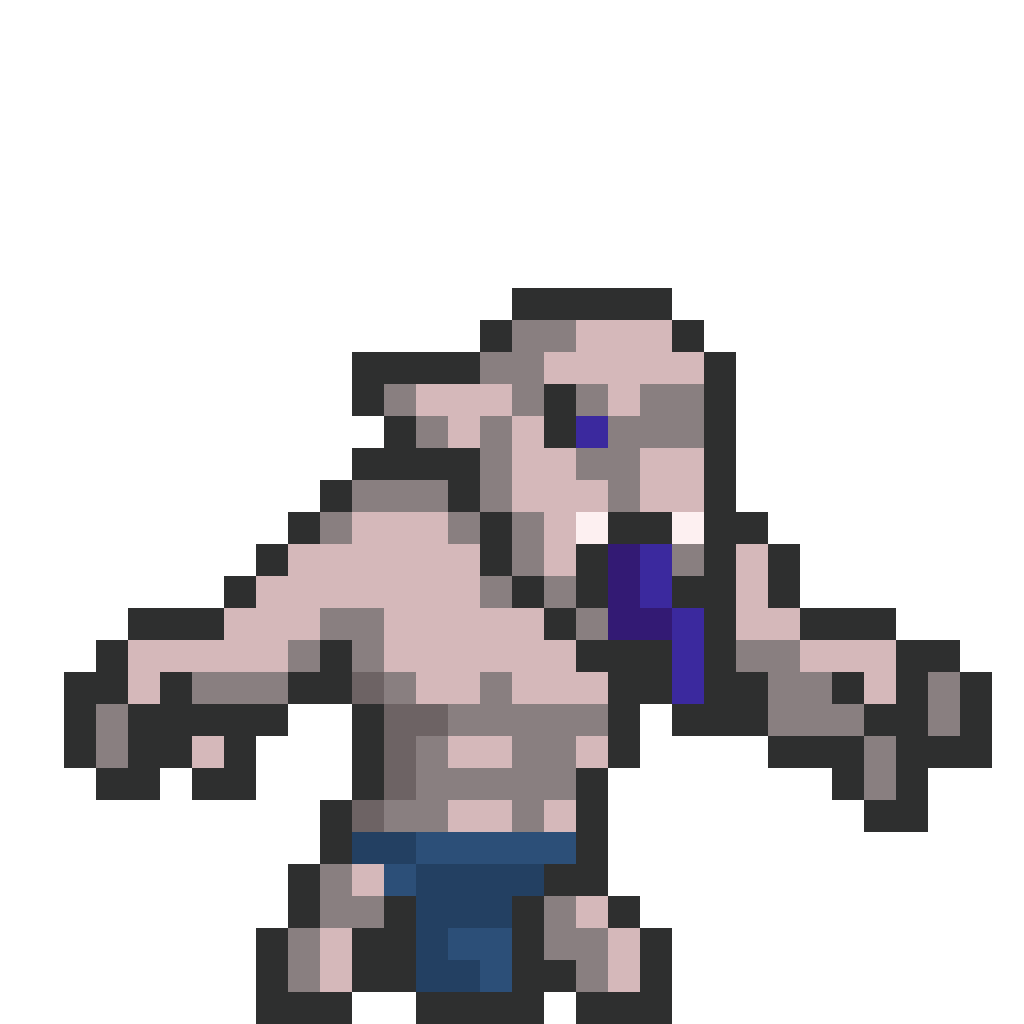

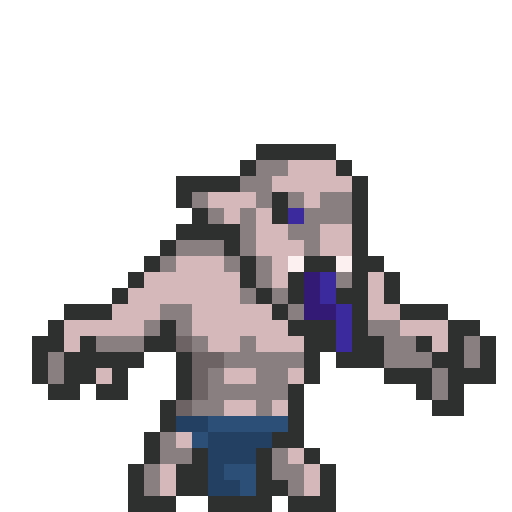

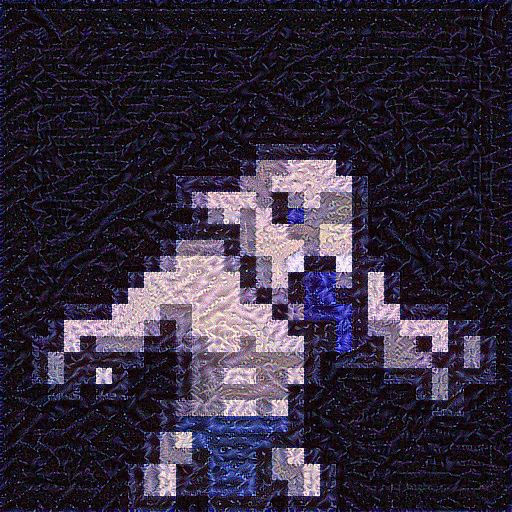

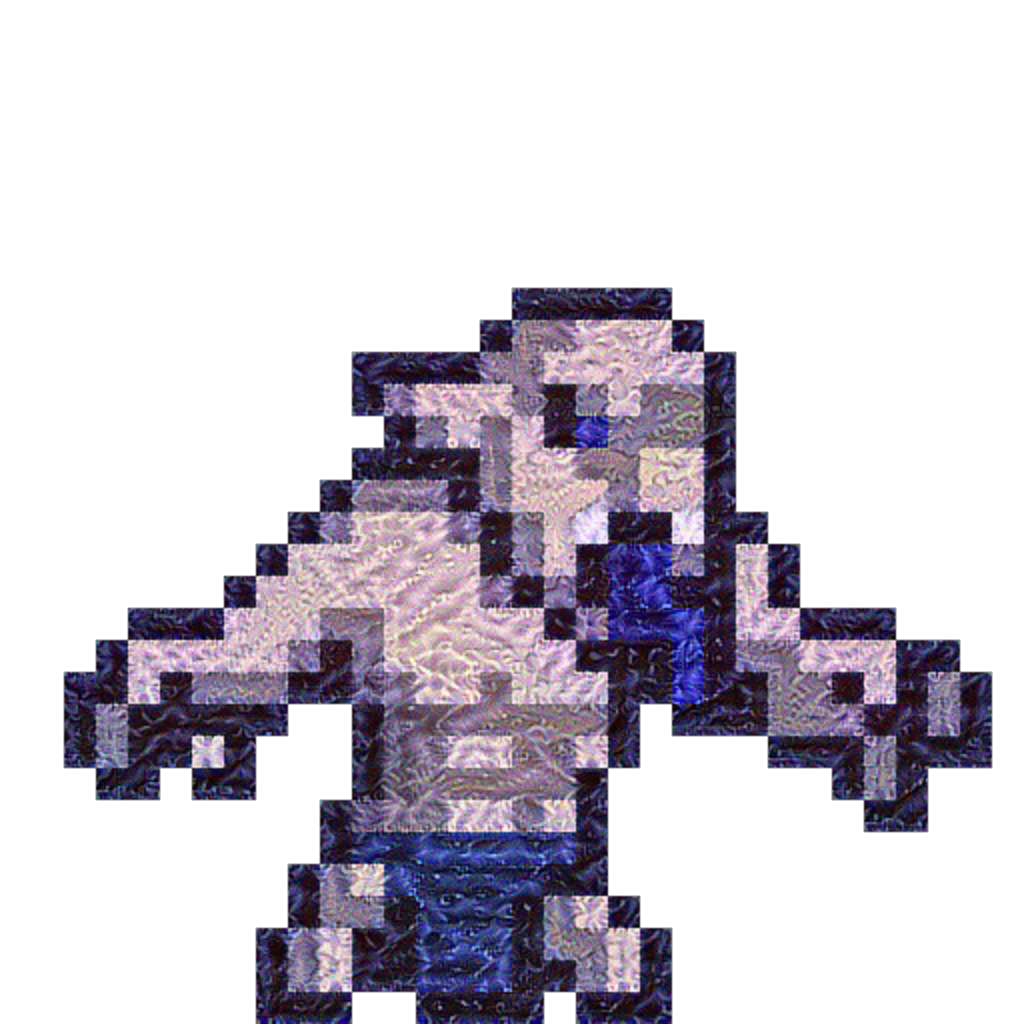

................................

In [18]:
# # main code

# 에셋출처 : https://assetstore.unity.com/packages/2d/characters/knight-sprite-sheet-free-93897#content
# dash_1 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e0.11128ebc-b5af-4a57-9f30-7ff1248c7ee2.png'
# dash_2 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e2.e4f4f2d4-547f-47af-a24b-b0c46368f69b.png'
# dash_3 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f472.8fb14c53-318c-46dc-a7d6-190c6234f499.png'
# imgUrls = [dash_1, dash_2, dash_3]

# ghoul_sprite_sheet/Layer 1_sprite_01.png
# file_list

import time
start = time.time()

for idx, elem in enumerate(file_list):
    location = file_list[idx]

    origin_image = img.imread(location)
    origin_image = np.array(tensor_to_image(origin_image))
    origin_image_shape = origin_image.shape

    # style transfer
    content_image, content_shape = load_img(location) 
    img_transformed = get_transformed_img(content_image)

    # model이 반환한 이미지와 사이즈 동일하게 origin image 변환(자동화 완료)
    shape = content_shape.numpy()
    x, y = shape
    origin_image_resized = cv2.resize(origin_image, dsize=(y,x))

    # alpha channel 추가
    final = cv2.cvtColor(img_transformed, cv2.COLOR_RGB2RGBA)
    final[:, :, 3] = origin_image_resized[:,:,3]

    # final image 사이즈를 original image 사이즈로 변환
    x, y = origin_image_shape[0], origin_image_shape[1]
    final = cv2.resize(final, dsize=(y,x))

    cv2.imwrite("Styled_Images/" + f'{idx}_final.png', final)
    cv2_imshow(origin_image)
    cv2_imshow(origin_image_resized)
    cv2_imshow(img_transformed)
    cv2_imshow(final)

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

# 여기서 끝나지 않고 무한 루프 되는 것 같음. 경로에 설정에 문제가 있나?